# Imports

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.onnx
import numpy as np

%matplotlib inline  
import matplotlib.pyplot as plt

# Simulate Data

In [0]:
# For this autocomplete example, we are just goint to simulate some
# data, but you could add any of your own example here.
text = ['hello how are you doing today',
        'i am doing well thank you',
        'i hope you have a nice day',
        'thank you for asking',
        'hi how is it going']

# Pre-process the data

In [0]:
# We are going to use a character level model, and thus we need to get all of 
# the unique characters in the examples (this will allow us to create a 
# dictionary of characters with corresponding index values).
chars = set(' '.join(text))

# Create an integer index to character mapping.
int2char = dict(enumerate(chars))

# Create a second mapping that maps characters to indices.
char2int = {char: idx for idx, char in int2char.items()}

In [4]:
# Take a look at our int2char mapping.
for k in int2char:
  print("index: ", k)
  print("char: ", int2char[k])
  print("")
  if k > 5:
    break

index:  0
char:  v

index:  1
char:  u

index:  2
char:  l

index:  3
char:  a

index:  4
char:  e

index:  5
char:  n

index:  6
char:   



In [5]:
# Ok, we have our character dictionary and our examples, but we need to create
# some vector representation of our characters for the RNN. In this case, we will
# use one hot encoding. 

# However, we will need to deal with a few issues. One is the fact that our
# input sequences all have different lengths. Second, we need to pre-process our
# text samples into feature, label pairs. Finally, we will need to create the
# one hot encoding representation of our characters. 

# First let's take care of "padding" the input sequences so they all have the 
# same length. max_length will hold the maximum sequence length.
max_length = len(max(text, key=len))

# Now pad the text samples with spaces.
for i in range(len(text)):
    while len(text[i])<max_length:
        text[i] += ' '

print(text)

['hello how are you doing today', 'i am doing well thank you    ', 'i hope you have a nice day   ', 'thank you for asking         ', 'hi how is it going           ']


In [6]:
# Next let's create our features and labels/ target for the model. In this case, our 
# features are a sequence of characters and our labels/ target is another 
# sequence of characters. 
inputs = []
targets = []

# For our samples, let's shift the text left/right to form inputs and targets.
for sample in text:

  # Remove the last character.
  inputs.append(sample[:-1])
  
  # Remove the first character.
  targets.append(sample[1:])
  print("Input Sequence: {}\nTarget Sequence: {}".format(inputs[-1], targets[-1]))
  print("")

Input Sequence: hello how are you doing toda
Target Sequence: ello how are you doing today

Input Sequence: i am doing well thank you   
Target Sequence:  am doing well thank you    

Input Sequence: i hope you have a nice day  
Target Sequence:  hope you have a nice day   

Input Sequence: thank you for asking        
Target Sequence: hank you for asking         

Input Sequence: hi how is it going          
Target Sequence: i how is it going           



In [7]:
# Convert our string samples into arrays of character values.
for idx, sample in enumerate(text):
  inputs[idx] = [char2int[character] for character in inputs[idx]]
  targets[idx] = [char2int[character] for character in targets[idx]]

print(inputs[1])

[18, 6, 3, 13, 6, 17, 21, 18, 5, 12, 6, 11, 4, 2, 2, 6, 14, 20, 3, 5, 9, 6, 10, 21, 1, 6, 6, 6]


In [0]:
# Let's take care of the one hot encoding of each of our character sequences
# into vectors for each character. First, create a dummy array of zeros with the 
# desired output shape.
features = np.zeros((len(text), max_length-1, len(char2int)), dtype=np.float32)

# Substitute a value of 1 at the relevant indices for the characters.
for i in range(len(text)):
  for j in range(max_length-1):
    features[i, j, inputs[i][j]] = 1

In [9]:
features[0][0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

In [0]:
# Convert our features and targets into tensors.
features_tensor = torch.from_numpy(features)
targets_tensor = torch.Tensor(targets)

# Define the model

In [0]:
# MyNet defines our PyTorch neural network model
class MyNet(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim):
      
    # call class constructor
    super(MyNet, self).__init__()

    # Defining some parameters
    self.hidden_dim = hidden_dim

    # Use the nn package to create the layers of our network.
    # First, we add a simple RNN Layer.
    self.rnn = nn.RNN(input_size, hidden_dim, 1, batch_first=True)

    # We then add a fully connected layer following the RNN layer to 
    # prepare our output.
    self.fc = nn.Linear(hidden_dim, output_size)
  
  def forward(self, x):

    # Because our RNN will process the inputs sequentially in pairs our (input, 
    # hidden state), we need to initialize the hidden state for the first pass
    # because it doesn't exist yet.
    batch_size = x.size(0)
    hidden = torch.zeros(1, batch_size, self.hidden_dim)

    # Next we pass the input (x) and hidden state into the RNN. 
    out, hidden = self.rnn(x, hidden)
    
    # Reshape the outputs and feed it through the fully connected layer.
    out = out.contiguous().view(-1, self.hidden_dim)
    out = self.fc(out)
    
    return out

In [0]:
# Intialize the model
model = MyNet(input_size=len(char2int), output_size=len(char2int), hidden_dim=12)

In [0]:
# Our error/loss function. 
criterion = nn.CrossEntropyLoss()

# Define our optimizer.
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model

In [14]:
# loop over our epochs
loss_values = []
for epoch in range(800):

  # clear the gradients
  optimiser.zero_grad()

  # calculate the predicted values
  predictions = model(features_tensor)

  # calculate our loss
  loss = criterion(predictions, targets_tensor.view(-1).long())
  loss_values.append(loss.item())

  # Backpropagate updates to our parameters.
  loss.backward()
  optimiser.step()

  # Print some info
  if epoch % 20 == 0:
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, loss))

Epoch: 1 	Training Loss: 3.077471
Epoch: 21 	Training Loss: 2.209830
Epoch: 41 	Training Loss: 1.525816
Epoch: 61 	Training Loss: 1.047221
Epoch: 81 	Training Loss: 0.730860
Epoch: 101 	Training Loss: 0.517084
Epoch: 121 	Training Loss: 0.371469
Epoch: 141 	Training Loss: 0.280530
Epoch: 161 	Training Loss: 0.217505
Epoch: 181 	Training Loss: 0.171244
Epoch: 201 	Training Loss: 0.236619
Epoch: 221 	Training Loss: 0.141579
Epoch: 241 	Training Loss: 0.111077
Epoch: 261 	Training Loss: 0.094866
Epoch: 281 	Training Loss: 0.082892
Epoch: 301 	Training Loss: 0.073602
Epoch: 321 	Training Loss: 0.066273
Epoch: 341 	Training Loss: 0.060389
Epoch: 361 	Training Loss: 0.055585
Epoch: 381 	Training Loss: 0.051606
Epoch: 401 	Training Loss: 0.048273
Epoch: 421 	Training Loss: 0.053687
Epoch: 441 	Training Loss: 0.156759
Epoch: 461 	Training Loss: 0.083384
Epoch: 481 	Training Loss: 0.058111
Epoch: 501 	Training Loss: 0.048330
Epoch: 521 	Training Loss: 0.043378
Epoch: 541 	Training Loss: 0.04023

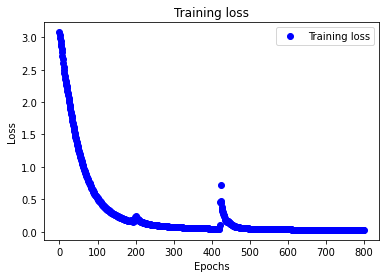

In [15]:
# Plot the training loss for each epoch to see how the model converged.
plt.plot(range(800), loss_values, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Try using the model

In [0]:
# In order to see the model work, we will have to define a couple of functions
# that will one hot encode our user input, pass it through the network
# and decode the output into characters.

# Prediction predicts a next character from a previous sequence.
def predict(model, chars):

  # One-hot encoding
  inputs = np.array([[char2int[c] for c in chars]])
  features = np.zeros((1, inputs.shape[1], len(char2int)), dtype=np.float32)
  for i in range(len(inputs)):
    for j in range(inputs.shape[1]):
      features[i, j, inputs[i][j]] = 1
  features = torch.from_numpy(features)
  
  # Make the prediction with the model.
  prediction = model(features)

  # Converting the output into character probabilities.
  prob = nn.functional.softmax(prediction[-1], dim=0).data

  # Output the character with the highest probability.
  char_ind = torch.max(prob, dim=0)[1].item()

  return int2char[char_ind]

# Predict a number of characters from start characters.
def sample(model, out_length, start_chars):

  # make sure the input is lower cased.
  start_chars = start_chars.lower()

  # Split into characters.
  chars = [c for c in start_chars]
  size = out_length - len(chars)

  # Pass the previous character and get a prediction for the next.
  for idx in range(size):
      char = predict(model, chars)
      chars.append(char)

  return ''.join(chars)

In [17]:
# Try some autocomplete!
sample(model, 17, 'hello')

'hello how are you'

In [18]:
sample(model, 17, 'hey')

'heyho  ane asking'

# Serialize model

In [19]:
# Serialize the model to a pickle file.
torch.save(model, 'autocomplete_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Load model back in for predictions

In [0]:
# Load the model back into memory from the file.
model_from_file = torch.load('autocomplete_model.pt')

In [21]:
sample(model_from_file, 17, 'hello')

'hello how are you'